In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest

In [ ]:
asset_name='QQQ'
date_col='date'
prediction='EMA1'

# startX  and end X and endX as predict date  must have in fin_movement_forecast
# For make prediction , startX is the starting day to use backward/the past 60 data to make prediction the next 10 day
startX='2023-06-26'    # use 60 past days since startX  to predict 2026-06-02 To 2026-06-11'
endX='2023-06-30'


In [3]:
json_credential_file=r'C:\Windows\pongthorn-5decdc5124f5.json'
projectId='pongthorn'
dataset_id='FinAssetForecast'

table_data_id=f"{projectId}.{dataset_id}.fin_data"
table_id = f"{projectId}.{dataset_id}.fin_movement_forecast"
print(table_id)
print(table_data_id)


credentials = service_account.Credentials.from_service_account_file(json_credential_file)
client = bigquery.Client(project=projectId,credentials=credentials )

pongthorn.FinAssetForecast.fin_movement_forecast
pongthorn.FinAssetForecast.fin_data


In [4]:
def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df



# Visualize All Feature on particualr period

In [5]:
# # For view chart
# startPriceData='2023-01-01'
# endPriceData='2023-06-01'
# sqlData=f"""
# SELECT * FROM `pongthorn.FinAssetForecast.fin_data` 
# where (Date>='{startPriceData}' and Date<='{endPriceData}')
# and Symbol='{asset_name}'
# """
# print(sqlData)

# dfData=load_data_bq(sqlData)
# dfData=dfData.set_index('Date')
# dfData=dfData.sort_index()

# plt.subplots(2, 1, figsize = (20, 10),sharex=True)

# ax1 = plt.subplot(2, 1, 1)
# plt.plot(dfData.index,dfData[['Close','EMA1','EMA2']])
# plt.ylabel('Price & EMA')

# ax2 = plt.subplot(2, 1, 2)
# plt.plot(dfData.index,dfData[['MACD','SIGNAL']])
# plt.xlabel('Date')
# plt.ylabel('MACD & Signal')

# plt.show()


In [6]:
def get_forecasting_result_data(request):

    if   request is not None:  
        start_date=request["start_date"]
        prediction_name=request["prediction_name"]
        asset_name=request["asset_name"]
    else:
        raise Exception("No request parameters such as start_date,prediction_name,asset_name")

    print("1.How far back in time does model want to apply as input to make prediction")

    sqlInput=f"""
    select t.pred_timestamp,t.asset_name,t.prediction_name,
    t_feature.input_date as {date_col},t_feature.input_feature as {prediction_name}
    from  `{table_id}` t
    cross join unnest(t.feature_for_prediction) t_feature
    where t.prediction_date='{start_date}' and t.asset_name='{asset_name}' and t.prediction_name='{prediction_name}'
    order by  t.pred_timestamp,t_feature.input_date
    """
    print(sqlInput)
    dfInput=load_data_bq(sqlInput)
    dfInput=dfInput.drop_duplicates(subset=[date_col,'asset_name','prediction_name'],keep='last',)
    dfInput[date_col]=pd.to_datetime(dfInput[date_col],format='%Y-%m-%d')
    dfInput.set_index(date_col,inplace=True)

    input_sequence_length=len(dfInput)
    print(f"input_sequence_length={input_sequence_length}")
    print("================================================================================================")

    print(dfInput.info())
    print(dfInput[['asset_name','prediction_name' ,prediction_name]])

    print("2.How far in advance does model want to  make prediction")


    sqlOutput=f"""
    select t.pred_timestamp,t.asset_name,t.prediction_name,
    t_pred.output_date as {date_col},t_pred.output_value as {prediction_name}
    from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
    cross join unnest(t.prediction_result) t_pred
    where t.prediction_date='{start_date}' and t.asset_name='{asset_name}' and t.prediction_name='{prediction_name}'
    order by  t.pred_timestamp,t_pred.output_date
    """
    print(sqlOutput)
    dfOutput=load_data_bq(sqlOutput)
    dfOutput=dfOutput.drop_duplicates(subset=[date_col,'asset_name','prediction_name'],keep='last',)
    dfOutput[date_col]=pd.to_datetime(dfOutput[date_col],format='%Y-%m-%d')
    dfOutput.set_index(date_col,inplace=True)

    output_sequence_length=len(dfOutput)
    print(f"output_sequence_length={output_sequence_length}")
    print("================================================================================================")

    print(dfOutput.info())
    print(dfOutput[['asset_name','prediction_name' ,prediction_name]])

    print("3.Get Real Data  to compare to prediction")

    # get actual data since the fist day of input and the last day of output(if covered)
    startFinData=dfInput.index.min().strftime('%Y-%m-%d')
    endFindData=dfOutput.index.max().strftime('%Y-%m-%d')

    sqlData=f"""
    select Date as {date_col},{prediction_name}, ImportDateTime, from `{table_data_id}` 
    where (Date>='{startFinData}' and Date<='{endFindData}') and Symbol='{asset_name}'
    order by ImportDateTime,Date
    """
    print(sqlData)

    dfRealData=load_data_bq(sqlData)
    dfRealData=dfRealData.drop_duplicates(subset=[date_col],keep='last',)
    dfRealData[date_col]=pd.to_datetime(dfRealData[date_col],format='%Y-%m-%d')
    dfRealData.set_index(date_col,inplace=True)
    print(dfRealData.info())
    print(dfRealData[[prediction_name]])


    return {'actual_price':dfRealData,'input':dfInput,'output':dfOutput }


# Visualize Prediction Result

In [7]:
dateRange=pd.date_range(start=startX,end=endX,freq='B')
print(dateRange)

noDaysT0Vis=len(dateRange)
if noDaysT0Vis>0:
    start_query=dateRange[0].strftime('%Y-%m-%d')
    end_query=dateRange[noDaysT0Vis-1].strftime('%Y-%m-%d')
    print(f"{noDaysT0Vis}-{start_query}-{end_query}")
    sqlDateRange=f"""
    select count(*) as noDaysT0Vis from `{table_id}` 
    where prediction_name='{prediction}' and  asset_name='{asset_name}' 
    and (prediction_date>='{start_query}' and prediction_date<='{end_query}')
    """
    print(sqlDateRange)
    dfXYZ=load_data_bq(sqlDateRange)
    if dfXYZ.iloc[0,0]!=noDaysT0Vis:
      raise Exception(f"No day to predict {noDaysT0Vis} != {dfXYZ.iloc[0,0]} No day in BQ")

DatetimeIndex(['2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29'], dtype='datetime64[ns]', freq='B')
4-2023-06-26-2023-06-29

    select count(*) as noDaysT0Vis from `pongthorn.FinAssetForecast.fin_movement_forecast` 
    where prediction_name='EMA1' and  asset_name='QQQ' 
    and (prediction_date>='2023-06-26' and prediction_date<='2023-06-29')
    


In [8]:
listDate =  [  d.strftime("%Y-%m-%d")  for d in dateRange.tolist()]
dictData={}
for d in listDate:
    print(f"==================================={d}===================================")
    request={'start_date':d,'prediction_name':prediction,'asset_name':asset_name}
    data=get_forecasting_result_data(request)
    dictData[d]=data  
    print(f"========================================================================")

===================================2023-06-26===================================
1.How far back in time does model want to apply as input to make prediction

    select t.pred_timestamp,t.asset_name,t.prediction_name,
    t_feature.input_date as date,t_feature.input_feature as EMA1
    from  `pongthorn.FinAssetForecast.fin_movement_forecast` t
    cross join unnest(t.feature_for_prediction) t_feature
    where t.prediction_date='2023-06-26' and t.asset_name='QQQ' and t.prediction_name='EMA1'
    order by  t.pred_timestamp,t_feature.input_date
    
input_sequence_length=30
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-05-12 to 2023-06-26
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   pred_timestamp   30 non-null     datetime64[ns, UTC]
 1   asset_name       30 non-null     object             
 2   prediction_name  30 non-null     object             
 3   EMA1

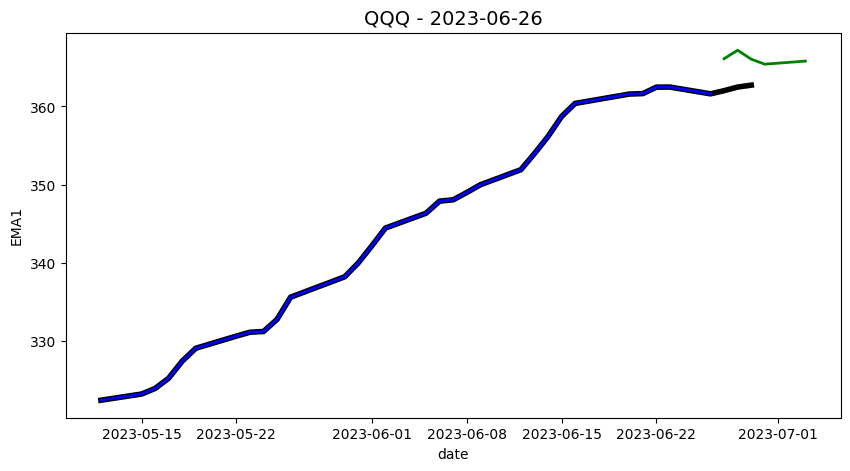

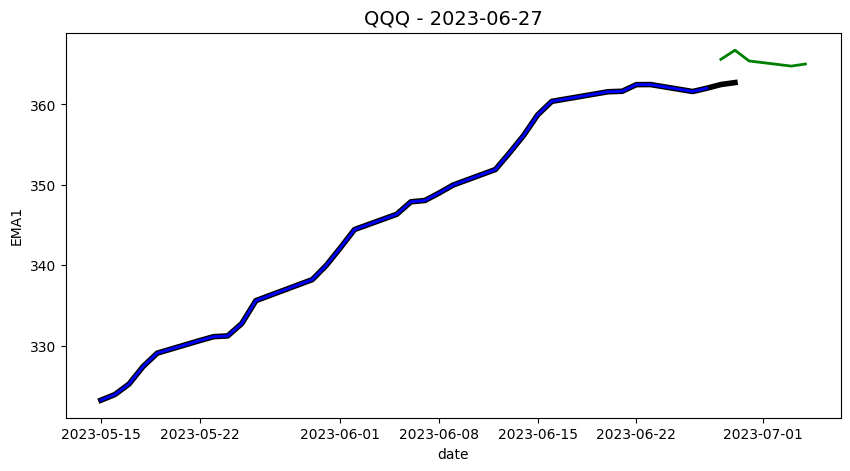

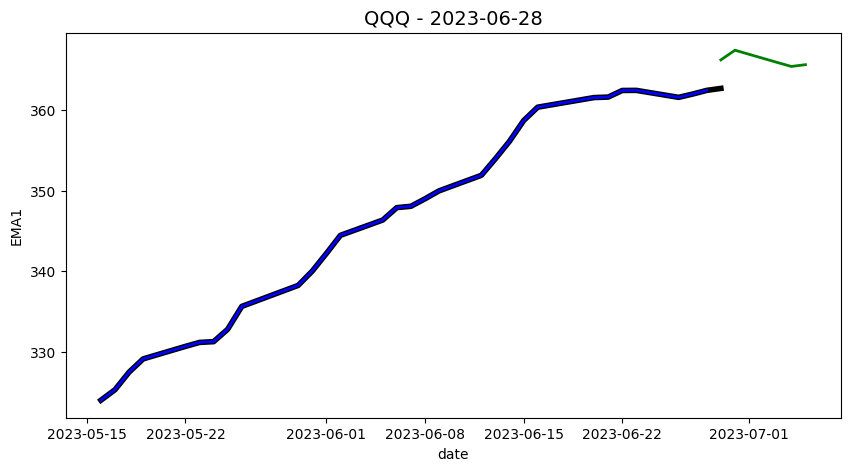

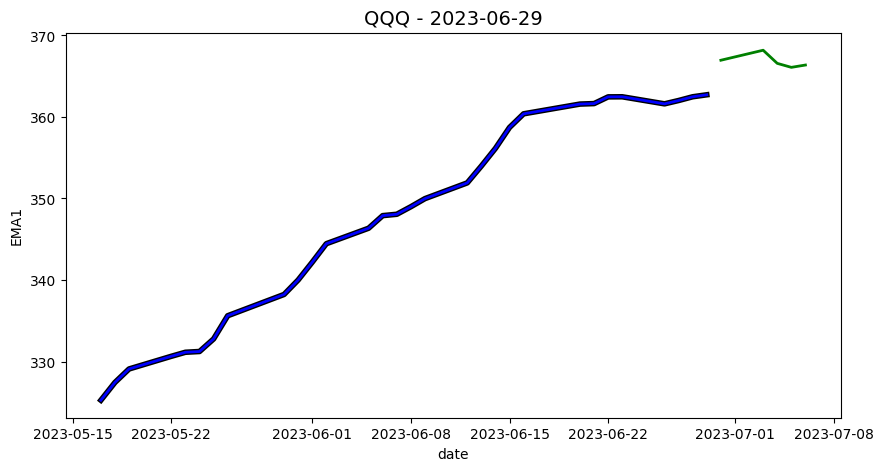

In [9]:
for d,data in dictData.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(f"{asset_name} - {d}", fontsize=14)
    sns.lineplot(data = data['actual_price'][prediction], linewidth=4.0,  markers='o',ax=ax,color='black')
    sns.lineplot(data = data['input'][prediction], linewidth=2.0, ax=ax,color='blue')
    sns.lineplot(data = data['output'][prediction], linewidth=2.0, ax=ax,color='green')

In [75]:
listMAE=[]
from sklearn.metrics import mean_absolute_error
for date,data in dictData.items():    
 print(f"============={date}=============")  
 dfPred=data['output'][[prediction]]
 dfPred.columns=[f'pred_{prediction}']

 dfX=data['actual_price'][[prediction]]
 dfX.columns=[f'actual_{prediction}']

 # print(dfPred)
 # print(dfX)
 dfCompare=pd.merge(left=dfPred,right=dfX,how='inner',right_index=True,left_index=True)
 print(dfCompare)    
 if dfCompare.empty==False:     
     MAE = mean_absolute_error(dfCompare[f'actual_{prediction}'], dfCompare[f'pred_{prediction}'])
     listMAE.append(MAE)
     print(f'MAE Actuat vs Pred: {np.round(MAE, 2)}')

=============2023-06-26=============
Empty DataFrame
Columns: [pred_EMA1, actual_EMA1]
Index: []


In [76]:
print(np.average(listMAE))

nan


D:\ProgramData\Anaconda3\envs\google_base\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
D:\ProgramData\Anaconda3\envs\google_base\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
